#**EDA U.S. Accidents (2016-2023)**

**Author:** `Panagiotis Kardatos, Mathematician`

**Date:** `Late October 2025`

**Data Source:** https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/data

This project performs an EDA on the U.S. Accidents Dataset across years 2016-2023. The dataset contains more than 7 millions records in during that time interval. The main objective is to analyze large scale data and extract meaningfull insights about time of accident, weather, and accident distribution across U.S. We will also utilize GPU for this project.




##**Step 1: Data Import and Load**

At this initial step we will:
*  Install and Import all the required libraries
*  Download the data and view the download path
*  Set Up the initial Dataframes

In [1]:
#GPU info for CUDA (Set GPU as an accelerator to your notebook)
!nvidia-smi

Wed Oct 29 08:55:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#Libraries Installation (For GPU and Kaggle)
!pip install cudf-cu12 --index-url=https://pypi.nvidia.com
!pip install kagglehub

Looking in indexes: https://pypi.nvidia.com


In [3]:
#Importing the libraries
import numpy as np
import cudf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import time
from google.colab import userdata  #For Personal info

In [4]:
#Kagglehub Personal Info
os.environ['KAGGLE_USERNAME'] = userdata.get('user')
os.environ['KAGGLE_KEY'] = userdata.get('key')

In [5]:
#Dataset Download
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
print(path)

Using Colab cache for faster access to the 'us-accidents' dataset.
/kaggle/input/us-accidents


In [6]:
#Full File Path
file_path = os.path.join(path, 'US_Accidents_March23.csv')
print(file_path)

/kaggle/input/us-accidents/US_Accidents_March23.csv


For Pandas we will use the chunksize approach. Let's see first the exact number of rows.

In [7]:
#Preview Number of rows before loading
with open(file_path, 'r') as f:
  row_count = sum(1 for _ in f)
print(row_count)

7728395


In [8]:
#Pandas DataFrame
start=time.time()
chunker = pd.read_csv(file_path, chunksize=500000) #Chunksize of 500k rows
df = next(chunker) # First Chunk out of 16
end=time.time()
print(f'{end-start:.2f}')


#cuDF Dataframe
start=time.time()
cf = cudf.read_csv(file_path)
end=time.time()
print(f'{end-start:.2f}')



3.53
2.43


As a first comment if we load to pandas the whole dataset, the system crashes so we chose the chunksize approach.

*  In Pandas we loaded 500k rows out of 7.72 million and it took 7.6 sec.

*  In Cudf, we loaded all 7.72 million rows and it took around 2.06 sec.

This is a first taste in GPU computational superiority over CPU in large scale datasets.

##**Step 2: Data Inspection**
At this step we will:
*  Get a first view of the data
*  Understand the column types, view the shape
*  Compute any missing values per column

###**Pandas**

In [9]:
#First Chunk
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [10]:
#General Information (first chunk)
print(f'{df.info()}\nSHAPE:{df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                0 non-null       float64
 8   End_Lng                0 non-null       float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            500000 non-null  object 
 11  Street                 500000 non-null  object 
 12  City                   499978 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

In [11]:
#Null Values For First Chunk
df.isnull().sum()

,0
ID,0
Source,0
Severity,0
Start_Time,0
End_Time,0
Start_Lat,0
Start_Lng,0
End_Lat,500000
End_Lng,500000
Distance(mi),0


###**CUDF**

In [12]:
#First View
cf.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,<NA>,<NA>,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,<NA>,<NA>,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,<NA>,<NA>,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,<NA>,<NA>,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,<NA>,<NA>,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [13]:
#Data Type and Shape
print(f'{cf.info()}\nSHAPE:{cf.shape}')

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype
---  ------                 -----
 0   ID                     object
 1   Source                 object
 2   Severity               int64
 3   Start_Time             object
 4   End_Time               object
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object
 11  Street                 object
 12  City                   object
 13  County                 object
 14  State                  object
 15  Zipcode                object
 16  Country                object
 17  Timezone               object
 18  Airport_Code           object
 19  Weather_Timestamp      object
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)            float64
 23  

In [14]:
#Null Values
cf.isna().sum()

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      

##**Step 3: Data Cleaning**
At this step we will clean data both in pandas and cudf. We will
*  Drop columns that are not related for the analysis and their null values can affect the size of the dataset
*  Drop rows with missing values
*  Drop duplicate rows
*  Define a Data Cleaning function for chunks

Missing values in numeric data will be filled with mean or median. They can also be predicted with machine learning techniques (multivariable linear regression) however this is outside of the scope of this project.

The deal here is to preserve as much data as possible. As it was stated above a Data Cleaning Function will be defined. This is because we will perform a loop later for all the chunks in chunker to be cleaned. More to follow.

###**Pandas**

####**Dropping Columns**

In [15]:
df.isnull().sum()

,0
ID,0
Source,0
Severity,0
Start_Time,0
End_Time,0
Start_Lat,0
Start_Lng,0
End_Lat,500000
End_Lng,500000
Distance(mi),0


We begin by dropping columns

In [16]:
#Drop Columns
df.drop(columns=['Start_Lat','Start_Lng','End_Lat','End_Lng','Description',
                 'Street','Timezone','Airport_Code','Weather_Timestamp',
                 'Wind_Chill(F)','Humidity(%)','Pressure(in)','Wind_Direction',
                 'Precipitation(in)','Amenity','Bump','Junction','No_Exit',
                 'Station','Traffic_Signal','Turning_Loop','Sunrise_Sunset',
                 'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'],
        inplace=True)

####**Filling Missing Values**

Now we will investigate what's better to fill the columns, `Temperature(F)`,`Visibility(mi)` and `Wind_Speed(mph)`, median or mean. The idea is to get a first view of sample's mean and median for each column, the extend it by state.
Then we will compute the the percentage: $\dfrac{mean-median}{median}\cdot 100\%$.

If the result percentage is between 2-5%, it's an indication that we have a small ammount of skewnewss. There are going going to be some outliers and it's up to us to decide. If it's over over 5% then we definitely need to use median. My approach is when >2% to use median.

In [17]:
#Calculating Sample's Mean and Median for Temp, Visibility, Wind Speed
print('Mean, Median')
print(f'{df['Temperature(F)'].mean():.1f}, {df['Temperature(F)'].median()}')
print(f'{df['Visibility(mi)'].mean():.1f},  {df['Visibility(mi)'].median()}')
print(f'{df['Wind_Speed(mph)'].mean():.1f},  {df['Wind_Speed(mph)'].median()}')

Mean, Median
64.7, 66.2
9.2,  10.0
8.9,  8.1


In [18]:
#Making an instant GroupBy Analysis by State
test=(df.groupby('State')[['Temperature(F)','Visibility(mi)','Wind_Speed(mph)']]
 .agg(['mean','median']))

#Calculating Percentage Diffrence of mean and median
for i in ['Temperature(F)','Visibility(mi)','Wind_Speed(mph)']:
  test[i+'_pct']=abs((test[(i,'mean')]-test[(i,'median')]))/test[(i,'median')]

#Creating a mask >0.02%
for i in ['Temperature(F)','Visibility(mi)','Wind_Speed(mph)']:
  test[i+'_mask']=test[i+'_pct']>0.02

#Creating Dictionaries for mean,median and masks, to get easier access.
temp_mean_dic = test[('Temperature(F)','mean')].to_dict()
temp_median_dic = test[('Temperature(F)','median')].to_dict()
temp_mask_dic = test['Temperature(F)_mask'].to_dict()

vis_mean_dic = test[('Visibility(mi)','mean')].to_dict()
vis_median_dic = test[('Visibility(mi)','median')].to_dict()
vis_mask_dic = test['Visibility(mi)_mask'].to_dict()

win_mean_dic = test[('Wind_Speed(mph)','mean')].to_dict()
win_median_dic = test[('Wind_Speed(mph)','median')].to_dict()
win_mask_dic = test['Wind_Speed(mph)_mask'].to_dict()

#A quick preview so far
test.head()

Temperature(F)        Visibility(mi)        Wind_Speed(mph)         \
                mean median           mean median            mean median   
State                                                                      
AL         80.975000  82.65      10.000000   10.0        3.500000    3.5   
CA         66.517473  64.90       9.322564   10.0        8.195351    6.9   
CT         54.979555  54.00       8.903463   10.0        8.923575    8.1   
DC         57.191811  55.00       9.292060   10.0        9.161186    8.1   
DE         64.412174  66.90       9.691228   10.0        8.949533    8.1   

      Temperature(F)_pct Visibility(mi)_pct Wind_Speed(mph)_pct  \
                                                                  
State                                                             
AL              0.020266           0.000000            0.000000   
CA              0.024923           0.067744            0.187732   
CT              0.018140           0.109654            0.101676   
DC              0.039851           0.070794            0.131011   
DE              0.037187           0.030877            0.104881   

      Temperature(F)_mask Visibility(mi)_mask Wind_Speed(mph)_mask  
                                                                    
State                                                               
AL                   True               False                False  
CA                   True                True                 True  
CT                  False                True                 True  
DC                   True                True                 True  
DE                   True                True                 True

In [19]:
#Defining Filling Functions
#We will apply the function by rows (axis=1)

#For Temperature
def fill_temp(row):
  if pd.isna(row['Temperature(F)']):
    if temp_mask_dic[row['State']]:
      return temp_median_dic[row['State']]
    else:
      return temp_mean_dic[row['State']]
  else:
    return row['Temperature(F)']

#For Visibility
def fill_vis(row):
  if pd.isna(row['Visibility(mi)']):
    if vis_mask_dic[row['State']]:
      return vis_median_dic[row['State']]
    else:
      return vis_mean_dic[row['State']]
  else:
    return row['Visibility(mi)']

#For Wind Speed
def fill_wind(row):
  if pd.isna(row['Wind_Speed(mph)']):
    if win_mask_dic[row['State']]:
      return win_median_dic[row['State']]
    else:
      return win_mean_dic[row['State']]
  else:
    return row['Wind_Speed(mph)']

In [20]:
#Mega Filling Function
def fill_rows(df):
  #For Temperature
  def fill_temp(row):
    if pd.isna(row['Temperature(F)']):
      if temp_mask_dic[row['State']]:
        return temp_median_dic[row['State']]
      else:
        return temp_mean_dic[row['State']]
    else:
      return row['Temperature(F)']
  df['Temperature(F)']=df.apply(fill_temp,axis=1)

  #For Visibility
  def fill_vis(row):
    if pd.isna(row['Visibility(mi)']):
      if vis_mask_dic[row['State']]:
        return vis_median_dic[row['State']]
      else:
        return vis_mean_dic[row['State']]
    else:
      return row['Visibility(mi)']
  df['Visibility(mi)']=df.apply(fill_vis,axis=1)

  #For Wind Speed
  def fill_wind(row):
    if pd.isna(row['Wind_Speed(mph)']):
      if win_mask_dic[row['State']]:
        return win_median_dic[row['State']]
      else:
        return win_mean_dic[row['State']]
    else:
      return row['Wind_Speed(mph)']
  df['Wind_Speed(mph)']=df.apply(fill_wind,axis=1)

  return df

In [21]:
#Applying the function to Fill values in  all 3 columns
start=time.time()
df=fill_rows(df)
end=time.time()
print(f'{end-start:.2f}')

#Verification
df.isnull().sum()

10.87


,0
ID,0
Source,0
Severity,0
Start_Time,0
End_Time,0
Distance(mi),0
City,22
County,0
State,0
Zipcode,58


####**Dropping Remaining Null Values**

In [22]:
#Drop Remaining NA's
df.dropna(inplace=True)
df.isna().sum()

,0
ID,0
Source,0
Severity,0
Start_Time,0
End_Time,0
Distance(mi),0
City,0
County,0
State,0
Zipcode,0


####**Duplicates Check**

In [23]:
#Duplicates Total Rows
df.duplicated().sum()

np.int64(0)

In [24]:
#Resetting Index
df.reset_index(drop=True, inplace=True)

####**Datetime Conversion**

If we apply `pd.to_datetime` it's possible to encounter errors in some chunks. This might be due to mixxed formats (date only or date + time combination). The approach here will be different. We will keep all Dates but we will exclude time so time analysis will be performed in GPU. This means that the end time column here is useless.

In [25]:
df.head()

,ID,Source,Severity,Start_Time,End_Time,Distance(mi),City,County,State,Zipcode,...,Temperature(F),Visibility(mi),Wind_Speed(mph),Weather_Condition,Crossing,Give_Way,Railway,Roundabout,Stop,Traffic_Calming
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,0.01,Dayton,Montgomery,OH,45424,...,36.9,10.0,9.2,Light Rain,False,False,False,False,False,False
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,0.01,Reynoldsburg,Franklin,OH,43068-3402,...,37.9,10.0,9.2,Light Rain,False,False,False,False,False,False
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,0.01,Williamsburg,Clermont,OH,45176,...,36.0,10.0,3.5,Overcast,False,False,False,False,False,False
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,0.01,Dayton,Montgomery,OH,45417,...,35.1,9.0,4.6,Mostly Cloudy,False,False,False,False,False,False
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,0.01,Dayton,Montgomery,OH,45459,...,36.0,6.0,3.5,Mostly Cloudy,False,False,False,False,False,False


In [26]:
#Type Conversion
df['Start_Time']=df['Start_Time'].astype('str')
df['End_Time']=df['End_Time'].astype('str')

In [27]:
#A clever way to take only date but not time + Drop End Time Column
df['Start_Time']=df['Start_Time'].apply(lambda x: x[0:10])
df.drop(columns='End_Time',inplace=True)

In [28]:
#Datetime Conversion
df['Start_Time']=pd.to_datetime(df['Start_Time'])

###**CUDF**

####**Dropping Columns**

In [29]:
#Drop Columns
start=time.time()
cf.drop(columns=['Start_Lat','Start_Lng','End_Lat','End_Lng','Description',
                 'Street','Timezone','Airport_Code','Weather_Timestamp',
                 'Wind_Chill(F)','Humidity(%)','Pressure(in)','Wind_Direction',
                 'Precipitation(in)','Amenity','Bump','Junction','No_Exit',
                 'Station','Traffic_Signal','Turning_Loop','Sunrise_Sunset',
                 'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'],
        inplace=True)
end=time.time()
print(f'{end-start:.2f}')

0.00


In [30]:
cf.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 21 columns):
 #   Column             Dtype
---  ------             -----
 0   ID                 object
 1   Source             object
 2   Severity           int64
 3   Start_Time         object
 4   End_Time           object
 5   Distance(mi)       float64
 6   City               object
 7   County             object
 8   State              object
 9   Zipcode            object
 10  Country            object
 11  Temperature(F)     float64
 12  Visibility(mi)     float64
 13  Wind_Speed(mph)    float64
 14  Weather_Condition  object
 15  Crossing           bool
 16  Give_Way           bool
 17  Railway            bool
 18  Roundabout         bool
 19  Stop               bool
 20  Traffic_Calming    bool
dtypes: bool(6), float64(4), int64(1), object(10)
memory usage: 1.3+ GB


####**Fillng Missing Values**

Again we will follow the same approach about filling with mean and median but this time we we will consider the whole DataFrame.

In [31]:
#Start by Groupping
start=time.time()
test2=(cf.groupby('State')[['Temperature(F)','Visibility(mi)','Wind_Speed(mph)']]
 .agg(['mean','median']))
end=time.time()
print(f'{end-start:.2f}')

0.87


In [32]:
#Preview
test2.head()

Temperature(F)        Visibility(mi)        Wind_Speed(mph)       
                mean median           mean median            mean median
State                                                                   
AL         66.488167   69.0       9.094628   10.0        6.392209    6.0
AR         59.852580   61.0       8.832653   10.0        7.074574    7.0
AZ         72.654621   73.0      10.212332   10.0        7.118711    6.9
CA         63.900452   63.0       9.089184   10.0        6.550965    6.0
CO         47.536737   46.9      11.280650   10.0        8.511995    7.0

In [33]:
#Sample's Mean and Median
print(f'Mean Median')
print(f"{cf['Temperature(F)'].mean():.1f} {cf['Temperature(F)'].median():.1f}")
print(f"{cf['Visibility(mi)'].mean():.1f}  {cf['Visibility(mi)'].median():.1f}")
print(f"{cf['Wind_Speed(mph)'].mean():.1f}  {cf['Wind_Speed(mph)'].median():.1f}")

Mean Median
61.7 64.0
9.1  10.0
7.7  7.0


In [34]:
#Percentage Difference for Median and Mean
for i in ['Temperature(F)','Visibility(mi)','Wind_Speed(mph)']:
  test2[i+'_pct']=abs(test2[(i,'mean')]-test2[(i,'median')])/test2[(i,'median')]

In [35]:
#Creating Masks
for i in ['Temperature(F)','Visibility(mi)','Wind_Speed(mph)']:
  test2[i+'_mask']=test2[i+'_pct']>0.02

In [36]:
#Creating Dictionaries for Instant Access
temp_mean_dic2 = test2[('Temperature(F)','mean')].to_dict()
temp_median_dic2 = test2[('Temperature(F)','median')].to_dict()
temp_mask_dic2 = test2['Temperature(F)_mask'].to_dict()

vis_mean_dic2 = test2[('Visibility(mi)','mean')].to_dict()
vis_median_dic2 = test2[('Visibility(mi)','median')].to_dict()
vis_mask_dic2 = test2['Visibility(mi)_mask'].to_dict()

win_mean_dic2 = test2[('Wind_Speed(mph)','mean')].to_dict()
win_median_dic2 = test2[('Wind_Speed(mph)','median')].to_dict()
win_mask_dic2 = test2['Wind_Speed(mph)_mask'].to_dict()

In [37]:
test2.head()

Temperature(F)        Visibility(mi)        Wind_Speed(mph)         \
                mean median           mean median            mean median   
State                                                                      
AL         66.488167   69.0       9.094628   10.0        6.392209    6.0   
AR         59.852580   61.0       8.832653   10.0        7.074574    7.0   
AZ         72.654621   73.0      10.212332   10.0        7.118711    6.9   
CA         63.900452   63.0       9.089184   10.0        6.550965    6.0   
CO         47.536737   46.9      11.280650   10.0        8.511995    7.0   

      Temperature(F)_pct Visibility(mi)_pct Wind_Speed(mph)_pct  \
                                                                  
State                                                             
AL              0.036403           0.090537            0.065368   
AR              0.018810           0.116735            0.010653   
AZ              0.004731           0.021233            0.031697   
CA              0.014293           0.091082            0.091827   
CO              0.013576           0.128065            0.215999   

      Temperature(F)_mask Visibility(mi)_mask Wind_Speed(mph)_mask  
                                                                    
State                                                               
AL                   True                True                 True  
AR                  False                True                False  
AZ                  False                True                 True  
CA                  False                True                 True  
CO                  False                True                 True

The apply-function is currently not working in cudf library. We will use a vectorized approach.

In [38]:
start=time.time()

#Temperature Fill
mask_temp=cf['Temperature(F)'].isna()
use_median_temp=cf['State'].map(temp_mask_dic2)
cf.loc[mask_temp & use_median_temp,'Temperature(F)']=cf['State'].map(temp_median_dic2)
cf.loc[mask_temp & ~use_median_temp,'Temperature(F)']=cf['State'].map(temp_mean_dic2)

#Visibility Fill
mask_vis=cf['Visibility(mi)'].isna()
use_median_vis=cf['State'].map(vis_mask_dic2)
cf.loc[mask_vis & use_median_vis,'Visibility(mi)']=cf['State'].map(vis_median_dic2)
cf.loc[mask_vis & ~use_median_vis,'Visibility(mi)']=cf['State'].map(vis_mean_dic2)

#Wind Speed Fill
mask_wind=cf['Wind_Speed(mph)'].isna()
use_median_wind=cf['State'].map(win_mask_dic2)
cf.loc[mask_wind & use_median_wind,'Wind_Speed(mph)']=cf['State'].map(win_median_dic2)
cf.loc[mask_wind & ~use_median_wind,'Wind_Speed(mph)']=cf['State'].map(win_mean_dic2)

end=time.time()
print(f'{end-start:.2f}')

0.61


####**Droppping Remaining Null Values**

In [39]:
#Drop Remaining NA's
cf.dropna(inplace=True)
cf.isna().sum()

ID                   0
Source               0
Severity             0
Start_Time           0
End_Time             0
Distance(mi)         0
City                 0
County               0
State                0
Zipcode              0
Country              0
Temperature(F)       0
Visibility(mi)       0
Wind_Speed(mph)      0
Weather_Condition    0
Crossing             0
Give_Way             0
Railway              0
Roundabout           0
Stop                 0
Traffic_Calming      0
dtype: int64

####**Duplicates Check**

In [40]:
#Duplicates Check
cf.duplicated().sum()

np.int64(0)

In [41]:
#Resetting Index
cf.reset_index(drop=True, inplace=True)

####**Datetime Conversion**

Conversion is triggering errors. This happens as the whole dataset has mixxed types of time formats. However even this approach will trigger arround 700k rows to get null values. We will find a different approach for this. A simpler way is to perform time analysis in the GPU. We will use regex to find dates that also include time. We will lose 700k rows since those rows only include date but not time.

In [42]:
cf.head()

,ID,Source,Severity,Start_Time,End_Time,Distance(mi),City,County,State,Zipcode,...,Temperature(F),Visibility(mi),Wind_Speed(mph),Weather_Condition,Crossing,Give_Way,Railway,Roundabout,Stop,Traffic_Calming
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,0.01,Dayton,Montgomery,OH,45424,...,36.9,10.0,8.1,Light Rain,False,False,False,False,False,False
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,0.01,Reynoldsburg,Franklin,OH,43068-3402,...,37.9,10.0,8.1,Light Rain,False,False,False,False,False,False
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,0.01,Williamsburg,Clermont,OH,45176,...,36.0,10.0,3.5,Overcast,False,False,False,False,False,False
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,0.01,Dayton,Montgomery,OH,45417,...,35.1,9.0,4.6,Mostly Cloudy,False,False,False,False,False,False
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,0.01,Dayton,Montgomery,OH,45459,...,36.0,6.0,3.5,Mostly Cloudy,False,False,False,False,False,False


In [43]:
#Start + End Time Conversion
cf['Start_Time'].astype('str')
cf['End_Time'].astype('str')

0          2016-02-08 11:00:00
1          2016-02-08 06:37:59
2          2016-02-08 07:19:27
3          2016-02-08 07:53:34
4          2016-02-08 08:09:07
                  ...         
7554688    2019-08-23 18:32:01
7554689    2019-08-23 19:38:23
7554690    2019-08-23 19:28:49
7554691    2019-08-23 19:29:42
7554692    2019-08-23 19:21:31
Name: End_Time, Length: 7554693, dtype: object

In [44]:
#Creating Masks with Regular Expressions
mas_start_time = (cf['Start_Time'].str
                  .match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$'))
mas_end_time = (cf['End_Time'].str
                .match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$'))

In [45]:
#Filtering
cf=cf[mas_start_time & mas_end_time].reset_index(drop=True)

In [46]:
#Datetime Conversion
cf['Start_Time']=cudf.to_datetime(cf['Start_Time'])
cf['End_Time']=cudf.to_datetime(cf['End_Time'])

###**Chunk Cleaning Function**
Since we are working with chunks we need to define a cleaning function that combines all steps we did in this section. This will clean every chunk.

In [47]:
#Cleaning Function

def clean_chunk(df):

  #Drop Columns
  df.drop(columns=['Start_Lat','Start_Lng','End_Lat','End_Lng','Description',
                 'Street','Timezone','Airport_Code','Weather_Timestamp',
                 'Wind_Chill(F)','Humidity(%)','Pressure(in)','Wind_Direction',
                 'Precipitation(in)','Amenity','Bump','Junction','No_Exit',
                 'Station','Traffic_Signal','Turning_Loop','Sunrise_Sunset',
                 'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'],
        inplace=True)

  #Filling Missing Values
  #Making an instant GroupBy Analysis by State
  test=(df.groupby('State')[['Temperature(F)','Visibility(mi)','Wind_Speed(mph)']]
  .agg(['mean','median']))

  #Calculating Percentage Diffrence of mean and median
  for i in ['Temperature(F)','Visibility(mi)','Wind_Speed(mph)']:
    test[i+'_pct']=abs((test[(i,'mean')]-test[(i,'median')]))/test[(i,'median')]

  #Creating a mask >0.02%
  for i in ['Temperature(F)','Visibility(mi)','Wind_Speed(mph)']:
    test[i+'_mask']=test[i+'_pct']>0.02

  #Creating Dictionaries for mean,median and masks, to get easier access.
  temp_mean_dic = test[('Temperature(F)','mean')].to_dict()
  temp_median_dic = test[('Temperature(F)','median')].to_dict()
  temp_mask_dic = test['Temperature(F)_mask'].to_dict()

  vis_mean_dic = test[('Visibility(mi)','mean')].to_dict()
  vis_median_dic = test[('Visibility(mi)','median')].to_dict()
  vis_mask_dic = test['Visibility(mi)_mask'].to_dict()

  win_mean_dic = test[('Wind_Speed(mph)','mean')].to_dict()
  win_median_dic = test[('Wind_Speed(mph)','median')].to_dict()
  win_mask_dic = test['Wind_Speed(mph)_mask'].to_dict()

    #For Temperature
  def fill_temp(row):
    if pd.isna(row['Temperature(F)']):
      if temp_mask_dic[row['State']]:
        return temp_median_dic[row['State']]
      else:
        return temp_mean_dic[row['State']]
    else:
      return row['Temperature(F)']

  #For Visibility
  def fill_vis(row):
    if pd.isna(row['Visibility(mi)']):
      if vis_mask_dic[row['State']]:
        return vis_median_dic[row['State']]
      else:
        return vis_mean_dic[row['State']]
    else:
      return row['Visibility(mi)']

  #For Wind Speed
  def fill_wind(row):
    if pd.isna(row['Wind_Speed(mph)']):
      if win_mask_dic[row['State']]:
        return win_median_dic[row['State']]
      else:
        return win_mean_dic[row['State']]
    else:
      return row['Wind_Speed(mph)']

  df['Temperature(F)'] = df.apply(fill_temp, axis=1)
  df['Visibility(mi)'] = df.apply(fill_vis, axis=1)
  df['Wind_Speed(mph)'] = df.apply(fill_wind, axis=1)


  #Drop Remaining NA's
  df.dropna(inplace=True)

  #Drop Duplicates
  df.drop_duplicates(inplace=True)

  #Datetime Conversion
  df['Start_Time']=df['Start_Time'].astype('str')
  df['End_Time']=df['End_Time'].astype('str')
  df['Start_Time']=df['Start_Time'].apply(lambda x: x[0:10])
  df.drop(columns='End_Time',inplace=True)
  df['Start_Time']=pd.to_datetime(df['Start_Time'])

  return df

##**Step 4: Feature Engineering**
At this step we will create useful features for our analysis.

For **Pandas Dataframe** we will:
*  Add Year, Month, Day, Day_of_Week (with name)
*  Temperature Conversion from Fahrenheit to Celsius
*  Convert Miles to Kilometers in the corresponding columns
*  Make Temp_Bins (according to Clesius) as follows:
   * \< 0 --> Very Cold
   * 0-10 --> Cold
   * 10-18 --> Cool-Mid Cool
   * 18-24 --> Mild-Comfortable
   * 24-30 --> Warm
   * 30-35 --> Hot
   * \> 35 --> Very Hot
*  Define a feature engineering function for every chunk



For **CUDF Dataframe** we will perform time Analysis only. We will create 3 columns.
*  The time the incident lasted (it can be classified to bins but we will come back later on the future about this since it is currently outside of the scope of this project)
*  We will extract the hour of time
*  We will create hour bins
    * 0-6 --> Night
    * 6-12 --> Morning
    * 12-18 --> Afternoon
    * 18-0 --> Evening

###**Pandas**

In [48]:
#Creating New Columns

#Extracting Dates
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.month_name()
df['Day']=df['Start_Time'].dt.day
df['Day_of_Week']=df['Start_Time'].dt.day_name()

#Fahrenheit -> Celsius + Miles -> Km
df['Temperature(C)']=((df['Temperature(F)']-32)*5/9).round(1)
df['Visbility(km)']=(df['Visibility(mi)']*1.60934).round(1)
df['Wind_Speed(km)']=(df['Wind_Speed(mph)']*1.60934).round(1)

In [49]:
#Temperature Binning
min=df['Temperature(C)'].min()
max=df['Temperature(C)'].max()
bins=[min-1,0,10,18,24,30,35,max+1]
labels=['Very Cold','Cold','Cool-Mid Cool','Mild-Comfortable',
        'Warm','Hot','Very Hot']

In [50]:
#Temp Bins
df['Temp_Bin']=pd.cut(df['Temperature(C)'],bins=bins,labels=labels)

In [51]:
df.head()

,ID,Source,Severity,Start_Time,Distance(mi),City,County,State,Zipcode,Country,...,Stop,Traffic_Calming,Year,Month,Day,Day_of_Week,Temperature(C),Visbility(km),Wind_Speed(km),Temp_Bin
0,A-1,Source2,3,2016-02-08,0.01,Dayton,Montgomery,OH,45424,US,...,False,False,2016,February,8,Monday,2.7,16.1,14.8,Cold
1,A-2,Source2,2,2016-02-08,0.01,Reynoldsburg,Franklin,OH,43068-3402,US,...,False,False,2016,February,8,Monday,3.3,16.1,14.8,Cold
2,A-3,Source2,2,2016-02-08,0.01,Williamsburg,Clermont,OH,45176,US,...,False,False,2016,February,8,Monday,2.2,16.1,5.6,Cold
3,A-4,Source2,3,2016-02-08,0.01,Dayton,Montgomery,OH,45417,US,...,False,False,2016,February,8,Monday,1.7,14.5,7.4,Cold
4,A-5,Source2,2,2016-02-08,0.01,Dayton,Montgomery,OH,45459,US,...,False,False,2016,February,8,Monday,2.2,9.7,5.6,Cold


###**Chunk Feature Engineering Function**

In [52]:
#Feature Engineering Function for Chunk

def feature_eng(df):
  #Extracting Dates
  df['Year']=df['Start_Time'].dt.year
  df['Month']=df['Start_Time'].dt.month_name()
  df['Day']=df['Start_Time'].dt.day
  df['Day_of_Week']=df['Start_Time'].dt.day_name()

  #Fahrenheit -> Celsius + Miles -> Km
  df['Temperature(C)']=((df['Temperature(F)']-32)*5/9).round(1)
  df['Visbility(km)']=(df['Visibility(mi)']*1.60934).round(1)
  df['Wind_Speed(km)']=(df['Wind_Speed(mph)']*1.60934).round(1)

  #Temperature Binning
  min=df['Temperature(C)'].min()
  max=df['Temperature(C)'].max()
  bins=[min-1,0,10,18,24,30,35,max+1]
  labels=['Very Cold','Cold','Cool-Mid Cool','Mild-Comfortable',
          'Warm','Hot','Very Hot']

  #Temp Bins
  df['Temp_Bin']=pd.cut(df['Temperature(C)'],bins=bins,labels=labels)
  return df

###**CUDF**

In [53]:
#Timedelta between Start_Time, End_time
cf['Time_Delta']=(cf['End_Time']-cf['Start_Time'])

In [54]:
#Hour + Binning
cf['Hour']=cf['Start_Time'].dt.hour
bins=[0,6,12,18,24]
labels=['Night','Morning','Afternoon','Evening']
cf['Hour_Bin']=cudf.cut(cf['Hour'],bins=bins,labels=labels,right=False)

In [55]:
cf.head()

,ID,Source,Severity,Start_Time,End_Time,Distance(mi),City,County,State,Zipcode,...,Weather_Condition,Crossing,Give_Way,Railway,Roundabout,Stop,Traffic_Calming,Time_Delta,Hour,Hour_Bin
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,0.01,Dayton,Montgomery,OH,45424,...,Light Rain,False,False,False,False,False,False,0 days 05:14:00,5,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,0.01,Reynoldsburg,Franklin,OH,43068-3402,...,Light Rain,False,False,False,False,False,False,0 days 00:30:00,6,Morning
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,0.01,Williamsburg,Clermont,OH,45176,...,Overcast,False,False,False,False,False,False,0 days 00:30:00,6,Morning
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,0.01,Dayton,Montgomery,OH,45417,...,Mostly Cloudy,False,False,False,False,False,False,0 days 00:30:00,7,Morning
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,0.01,Dayton,Montgomery,OH,45459,...,Mostly Cloudy,False,False,False,False,False,False,0 days 00:30:00,7,Morning


##**Step 5: Statistical Analysis**
At this step we will perfrom a groupby analysis where general analysis will occur from Pandas Dataframe and Time Analysis from CUDF Dataframe.

###**Pandas**

In [56]:
df.head()

,ID,Source,Severity,Start_Time,Distance(mi),City,County,State,Zipcode,Country,...,Stop,Traffic_Calming,Year,Month,Day,Day_of_Week,Temperature(C),Visbility(km),Wind_Speed(km),Temp_Bin
0,A-1,Source2,3,2016-02-08,0.01,Dayton,Montgomery,OH,45424,US,...,False,False,2016,February,8,Monday,2.7,16.1,14.8,Cold
1,A-2,Source2,2,2016-02-08,0.01,Reynoldsburg,Franklin,OH,43068-3402,US,...,False,False,2016,February,8,Monday,3.3,16.1,14.8,Cold
2,A-3,Source2,2,2016-02-08,0.01,Williamsburg,Clermont,OH,45176,US,...,False,False,2016,February,8,Monday,2.2,16.1,5.6,Cold
3,A-4,Source2,3,2016-02-08,0.01,Dayton,Montgomery,OH,45417,US,...,False,False,2016,February,8,Monday,1.7,14.5,7.4,Cold
4,A-5,Source2,2,2016-02-08,0.01,Dayton,Montgomery,OH,45459,US,...,False,False,2016,February,8,Monday,2.2,9.7,5.6,Cold


####**General Analysis**

In [57]:
#State with most accidents
kf1=(df.groupby('State').size().sort_values(ascending=False)
    .reset_index(name='Count'))

kf1

,State,Count
0,CA,172237
1,TX,76165
2,FL,49027
3,PA,30440
4,MI,25069
5,NY,24803
6,GA,18482
7,IL,17096
8,OH,11469
9,WA,11266


In [58]:
#County of each state with most crashes
kf2=(df.groupby(['State','County']).size()
    .reset_index(name='Count').sort_values(by='Count',ascending=False)
    .groupby('State').head(1))

kf2

,State,County,Count
13,CA,Los Angeles,61721
641,TX,Harris,27181
582,PA,Montgomery,13990
377,MI,Genesee,9276
80,FL,Orange,8659
131,GA,Fulton,8017
705,WA,King,7530
428,NE,Douglas,6856
518,OH,Montgomery,6001
479,NY,Westchester,5474


In [59]:
#Accidents per Year
kf3=(df.groupby('Year').size().reset_index(name='Count'))

kf3

,Year,Count
0,2016,275686
1,2017,214108


In [60]:
#Accidents per Month
kf4=(df.groupby('Month').size().reset_index(name='Count')
    .sort_values(by='Count',ascending=False))

kf4

,Month,Count
6,June,51464
9,November,45463
0,April,44877
5,July,43856
7,March,42536
2,December,39817
11,September,38852
1,August,37859
4,January,37729
10,October,37250


In [61]:
#Accidents per day of week
kf5=(df.groupby('Day_of_Week').size().reset_index(name='Count')
    .sort_values(by='Count',ascending=False))

kf5

,Day_of_Week,Count
4,Thursday,88453
5,Tuesday,87887
6,Wednesday,87567
0,Friday,85540
1,Monday,82243
2,Saturday,30828
3,Sunday,27276


In [62]:
#Accidents per Temperature Bin
kf6=(df.groupby('Temp_Bin').size().reset_index(name='Count')
    .sort_values(by='Count',ascending=False))

kf6

/tmp/ipython-input-826879175.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kf6=(df.groupby('Temp_Bin').size().reset_index(name='Count')


,Temp_Bin,Count
2,Cool-Mid Cool,133204
3,Mild-Comfortable,126897
4,Warm,100064
1,Cold,68705
5,Hot,33593
0,Very Cold,22939
6,Very Hot,4392


####**Multivariable Analysis**

In [63]:
#Most Accidents by Year and State (Top3 States)
kf7=(df.groupby(['Year','State']).size().reset_index(name='Count')
    .sort_values(by=['Year','Count'], ascending=[True,False])
    .groupby('Year').head(3))

kf7

,Year,State,Count
0,2016,CA,104240
23,2016,TX,39517
4,2016,FL,26434
29,2017,CA,67997
52,2017,TX,36648
33,2017,FL,22593


In [64]:
#Most Accidents by Year and Month (Top3 Months)
kf8=(df.groupby(['Year','Month']).size().reset_index(name='Count')
    .sort_values(by=['Year','Count'],ascending=[True,False])
    .groupby('Year').head(3))

kf8

,Year,Month,Count
8,2016,November,45463
2,2016,December,39817
10,2016,September,38852
16,2017,March,38720
13,2017,January,37729
12,2017,February,34544


In [65]:
#Most Accidents by Year and Day-of-Week
kf9=(df.groupby(['Year','Day_of_Week']).size().reset_index(name='Count')
    .sort_values(by=['Year','Count'],ascending=[True,False])
    .groupby('Year').head(7))

kf9

,Year,Day_of_Week,Count
5,2016,Tuesday,51106
6,2016,Wednesday,50642
4,2016,Thursday,50511
0,2016,Friday,46950
1,2016,Monday,46337
2,2016,Saturday,16162
3,2016,Sunday,13978
7,2017,Friday,38590
11,2017,Thursday,37942
13,2017,Wednesday,36925


In [66]:
#By Year + Temp Bin (Top3 Weather Bins)
kf10=(df.groupby(['Year','Temp_Bin']).size().reset_index(name='Count')
      .sort_values(by=['Year','Count'],ascending=[True,False])
      .groupby('Year').head(3))

kf10

/tmp/ipython-input-2859362990.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kf10=(df.groupby(['Year','Temp_Bin']).size().reset_index(name='Count')


,Year,Temp_Bin,Count
3,2016,Mild-Comfortable,75469
2,2016,Cool-Mid Cool,67784
4,2016,Warm,65555
9,2017,Cool-Mid Cool,65420
10,2017,Mild-Comfortable,51428
8,2017,Cold,38365


####**Conclusion from all chunks**

As you've seen all theese results do come from the first chunk. Above's code seems to work well so now we need to embed the other chunks as well. For each result above we created a dataframe. So the approach is to create the same number of lists as the dataframes above and each list contain the similar groupby analysis performed on every chunk. Then for each list we will concat all the included dataframes.

In [67]:
start=time.time()
#Creating The Loop for analyzing all the dataset
KF1=[]
KF2=[]
KF3=[]
KF4=[]
KF5=[]
KF6=[]
KF7=[]
KF8=[]
KF9=[]
KF10=[]

chunker = pd.read_csv(file_path, chunksize=500000) #Creating the chunker again

for df in chunker:
  clean_chunk(df) #Cleaning Chunk
  feature_eng(df) #Feature Engineering Chunk

  #State with most accidents
  kf1=(df.groupby('State').size().sort_values(ascending=False)
      .reset_index(name='Count'))

  KF1.append(kf1)

  #County of each state with most crashes
  kf2=(df.groupby(['State','County']).size()
      .reset_index(name='Count').sort_values(by='Count',ascending=False)
      .groupby('State').head(1))

  KF2.append(kf2)

  #Accidents per Year
  kf3=(df.groupby('Year').size().reset_index(name='Count'))

  KF3.append(kf3)

  #Accidents per Month
  kf4=(df.groupby('Month').size().reset_index(name='Count')
      .sort_values(by='Count',ascending=False))

  KF4.append(kf4)

  #Accidents per day of week
  kf5=(df.groupby('Day_of_Week').size().reset_index(name='Count')
      .sort_values(by='Count',ascending=False))

  KF5.append(kf5)

  #Accidents per Temperature Bin
  kf6=(df.groupby('Temp_Bin').size().reset_index(name='Count')
      .sort_values(by='Count',ascending=False))

  KF6.append(kf6)

  #Most Accidents by Year and State (Top3 States)
  kf7=(df.groupby(['Year','State']).size().reset_index(name='Count')
      .sort_values(by=['Year','Count'], ascending=[True,False])
      .groupby('Year').head(3))

  KF7.append(kf7)

  #Most Accidents by Year and Month (Top3 Months)
  kf8=(df.groupby(['Year','Month']).size().reset_index(name='Count')
      .sort_values(by=['Year','Count'],ascending=[True,False])
      .groupby('Year').head(3))

  KF8.append(kf8)

  #Most Accidents by Year and Day-of-Week
  kf9=(df.groupby(['Year','Day_of_Week']).size().reset_index(name='Count')
      .sort_values(by=['Year','Count'],ascending=[True,False])
      .groupby('Year').head(7))

  KF9.append(kf9)

  #By Year + Temp Bin (Top3 Weather Bins)
  kf10=(df.groupby(['Year','Temp_Bin']).size().reset_index(name='Count')
        .sort_values(by=['Year','Count'],ascending=[True,False])
        .groupby('Year').head(3))

  KF10.append(kf10)

end=time.time()
print(f'The time it took was: {end-start:.2f}')

/tmp/ipython-input-12110409.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kf6=(df.groupby('Temp_Bin').size().reset_index(name='Count')
/tmp/ipython-input-12110409.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kf10=(df.groupby(['Year','Temp_Bin']).size().reset_index(name='Count')
/tmp/ipython-input-12110409.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kf6=(df.groupby('Temp_Bin').size().reset_index(na

The time it took was: 256.20


/tmp/ipython-input-12110409.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kf6=(df.groupby('Temp_Bin').size().reset_index(name='Count')
/tmp/ipython-input-12110409.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kf10=(df.groupby(['Year','Temp_Bin']).size().reset_index(name='Count')


In [68]:
#Concatenating all the above DataFrames in each list
KF1=pd.concat(KF1, axis=0, ignore_index=True)
KF2=pd.concat(KF2, axis=0, ignore_index=True)
KF3=pd.concat(KF3, axis=0, ignore_index=True)
KF4=pd.concat(KF4, axis=0, ignore_index=True)
KF5=pd.concat(KF5, axis=0, ignore_index=True)
KF6=pd.concat(KF6, axis=0, ignore_index=True)
KF7=pd.concat(KF7, axis=0, ignore_index=True)
KF8=pd.concat(KF8, axis=0, ignore_index=True)
KF9=pd.concat(KF9, axis=0, ignore_index=True)
KF10=pd.concat(KF10, axis=0, ignore_index=True)

Now since all data are collected and merged from each dataframe it's time to get the final results.

In [69]:
#State with most accidents
KF1=(KF1.groupby('State')['Count']
     .sum().reset_index()
     .sort_values(by='Count',ascending=False))
KF1

,State,Count
3,CA,1701644
8,FL,870259
41,TX,573638
38,SC,375402
32,NY,345206
25,NC,334204
36,PA,290596
43,VA,285338
21,MN,189007
35,OR,176442


In [70]:
#County of each state with most crashes
KF2=(KF2.groupby(['State','County'])['Count'].sum().reset_index()
    .sort_values(by='Count',ascending=False)
    .groupby('State').head(1))

KF2

,State,County,Count
6,CA,Los Angeles,510723
13,FL,Miami-Dade,241573
98,TX,Harris,124999
54,NC,Mecklenburg,111451
5,AZ,Maricopa,103414
96,TN,Davidson,95219
29,LA,East Baton Rouge,74232
82,PA,Montgomery,66174
20,IL,Cook,60289
43,MN,Hennepin,58888


In [71]:
#Accidents per Year
KF3=(KF3.groupby('Year')['Count']
     .sum().reset_index())

KF3

,Year,Count
0,2016,402239
1,2017,700517
2,2018,871896
3,2019,936059
4,2020,1148892
5,2021,1531387
6,2022,1723701
7,2023,240002


In [72]:
#Accidents by Month
KF4=(KF4.groupby('Month')['Count']
     .sum().reset_index()
     .sort_values(by='Count',ascending=False))

KF4

,Month,Count
2,December,827345
9,November,739924
4,January,733784
10,October,660722
3,February,645712
11,September,635972
1,August,586225
0,April,577550
6,June,556552
8,May,548498


In [73]:
#Accidents by Day of Week
KF5=(KF5.groupby('Day_of_Week')['Count']
     .sum().reset_index()
     .sort_values(by='Count',ascending=False))

KF5

,Day_of_Week,Count
0,Friday,1335915
4,Thursday,1289321
6,Wednesday,1285505
5,Tuesday,1264145
1,Monday,1184753
2,Saturday,651356
3,Sunday,543698


In [74]:
#Accidents per Temperature Bin
KF6=(KF6.groupby('Temp_Bin')['Count']
     .sum().reset_index()
     .sort_values(by='Count',ascending=False))

KF6

/tmp/ipython-input-3374496791.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  KF6=(KF6.groupby('Temp_Bin')['Count']


,Temp_Bin,Count
2,Cool-Mid Cool,1858521
3,Mild-Comfortable,1693460
1,Cold,1422222
4,Warm,1414258
0,Very Cold,612336
5,Hot,473166
6,Very Hot,80730


In [75]:
#Most Accidents by Year and State (Top3 States)
KF7=(KF7.groupby(['Year','State'])['Count'].sum().reset_index()
    .sort_values(by=['Year','Count'],ascending=[True,False])
    .groupby('Year').head(3))

KF7

,Year,State,Count
1,2016,CA,138224
4,2016,TX,48813
3,2016,FL,36437
6,2017,CA,150063
12,2017,TX,82577
7,2017,FL,36829
13,2018,CA,153963
19,2018,TX,77829
18,2018,SC,43827
22,2019,CA,208405


In [76]:
#Most Accidents by Year and Month (Top Month)
KF8=(KF8.groupby(['Year','Month'])['Count'].sum().reset_index()
    .sort_values(by=['Year','Count'],ascending=[True,False])
    .groupby('Year').head(1)) #Change head number to spot Top n Months per Year

KF8

,Year,Month,Count
2,2016,November,63525
5,2017,August,78808
22,2018,November,80567
32,2019,October,104719
42,2020,November,164184
46,2021,December,176689
54,2022,April,193400
60,2023,January,156379


In [77]:
#Most Accidents by Year and Day-of-Week
KF9=(KF9.groupby(['Year','Day_of_Week'])['Count'].sum().reset_index()
    .sort_values(by=['Year','Count'],ascending=[True,False])
    .groupby('Year').head(1))

KF9

,Year,Day_of_Week,Count
5,2016,Tuesday,76088
7,2017,Friday,131185
19,2018,Tuesday,161693
26,2019,Tuesday,168209
32,2020,Thursday,200048
35,2021,Friday,275870
42,2022,Friday,301220
54,2023,Tuesday,40350


In [78]:
#By Year + Temp Bin (Top3 Weather Bins)
KF10=(KF10.groupby(['Year','Temp_Bin'])['Count'].sum().reset_index()
      .sort_values(by=['Year','Count'],ascending=[True,False])
      .groupby('Year').head(1))

KF10

/tmp/ipython-input-4064479854.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  KF10=(KF10.groupby(['Year','Temp_Bin'])['Count'].sum().reset_index()


,Year,Temp_Bin,Count
3,2016,Mild-Comfortable,107216
9,2017,Cool-Mid Cool,179500
16,2018,Cool-Mid Cool,210084
23,2019,Cool-Mid Cool,239857
30,2020,Cool-Mid Cool,324132
37,2021,Cool-Mid Cool,357277
45,2022,Mild-Comfortable,397924
50,2023,Cold,93365


###**CUDF Time Analysis**

In [79]:
cf.head()

,ID,Source,Severity,Start_Time,End_Time,Distance(mi),City,County,State,Zipcode,...,Weather_Condition,Crossing,Give_Way,Railway,Roundabout,Stop,Traffic_Calming,Time_Delta,Hour,Hour_Bin
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,0.01,Dayton,Montgomery,OH,45424,...,Light Rain,False,False,False,False,False,False,0 days 05:14:00,5,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,0.01,Reynoldsburg,Franklin,OH,43068-3402,...,Light Rain,False,False,False,False,False,False,0 days 00:30:00,6,Morning
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,0.01,Williamsburg,Clermont,OH,45176,...,Overcast,False,False,False,False,False,False,0 days 00:30:00,6,Morning
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,0.01,Dayton,Montgomery,OH,45417,...,Mostly Cloudy,False,False,False,False,False,False,0 days 00:30:00,7,Morning
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,0.01,Dayton,Montgomery,OH,45459,...,Mostly Cloudy,False,False,False,False,False,False,0 days 00:30:00,7,Morning


In [80]:
#Hour of day with most accidents
CF1=(cf.groupby('Hour').size().reset_index(name='Count')
    .sort_values(by='Count',ascending=False))

CF1

,Hour,Count
18,7,535513
0,8,530498
17,16,510046
10,17,506508
13,15,453717
1,14,386136
14,18,382511
7,6,366468
5,13,344612
3,9,326701


In [81]:
#Hour Bin with most crashes
CF2=(cf.groupby('Hour_Bin').size().reset_index(name='Count')
    .sort_values(by='Count',ascending=False))

CF2

,Hour_Bin,Count
2,Afternoon,2511094
1,Morning,2381027
3,Evening,1257198
0,Night,680229


In [82]:
#Hour with most Accidents per State
CF3=(cf.groupby(['State','Hour']).size().reset_index(name='Count')
    .sort_values(by=['State','Count'],ascending=[True,False])
    .groupby('State').head(1))

CF3

,State,Hour,Count
412,AL,17,9551
245,AR,7,1478
255,AZ,16,12716
810,CA,17,107163
1117,CO,7,10555
426,CT,16,4769
499,DC,8,1364
986,DE,8,1542
944,FL,8,61348
268,GA,7,13721


##**Step 6: Visualization**
At this step we will visualize most of the preeceding work. We will start with Pandas General Analysis and continue with CUDF Time-Analysis.


###**Pandas**

/tmp/ipython-input-2838209738.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0','200K','400K','600K','800K','1M','1.2M','1.4M','1.6M'],fontsize=12)
/tmp/ipython-input-2838209738.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=12)


Text(0, 0.5, 'Count')

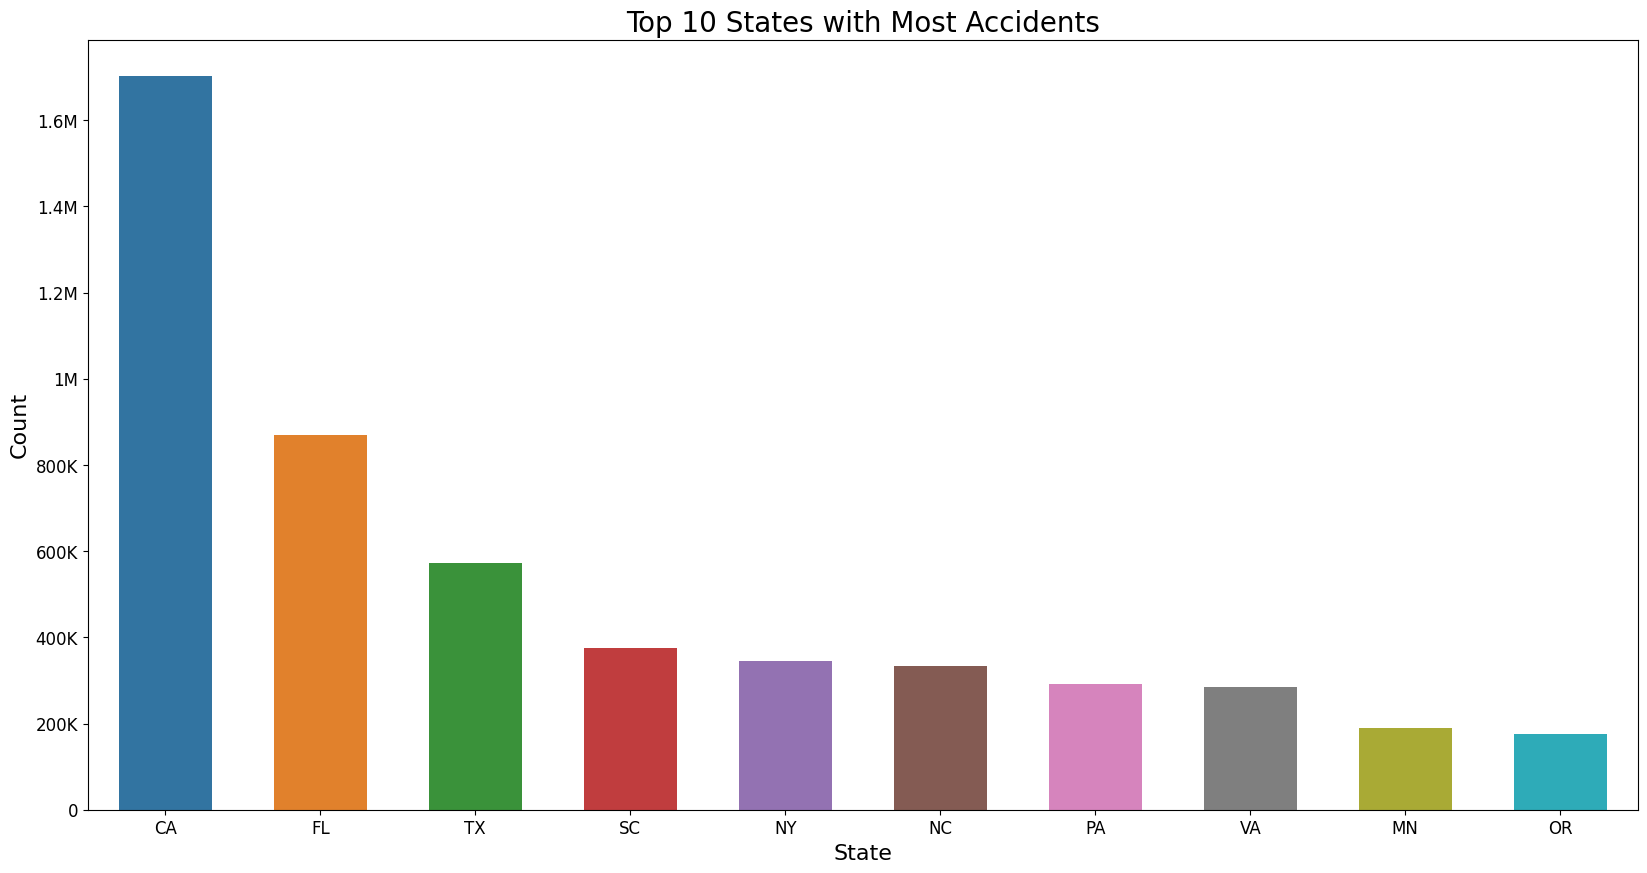

In [83]:
#State with Most Accidents (TOP 10)
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(1,1,1)
sns.barplot(data=KF1.iloc[:10,:],x='State',y='Count',width=0.6,hue='State')
ax.set_yticklabels(['0','200K','400K','600K','800K','1M','1.2M','1.4M','1.6M'],fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12)
ax.set_title('Top 10 States with Most Accidents',fontsize=20)
ax.set_xlabel('State',fontsize=16)
ax.set_ylabel('Count',fontsize=16)

/tmp/ipython-input-2389414863.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=12)
/tmp/ipython-input-2389414863.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0','100K','200K','300K','400K','500K'],fontsize=12)


Text(0, 0.5, 'Count')

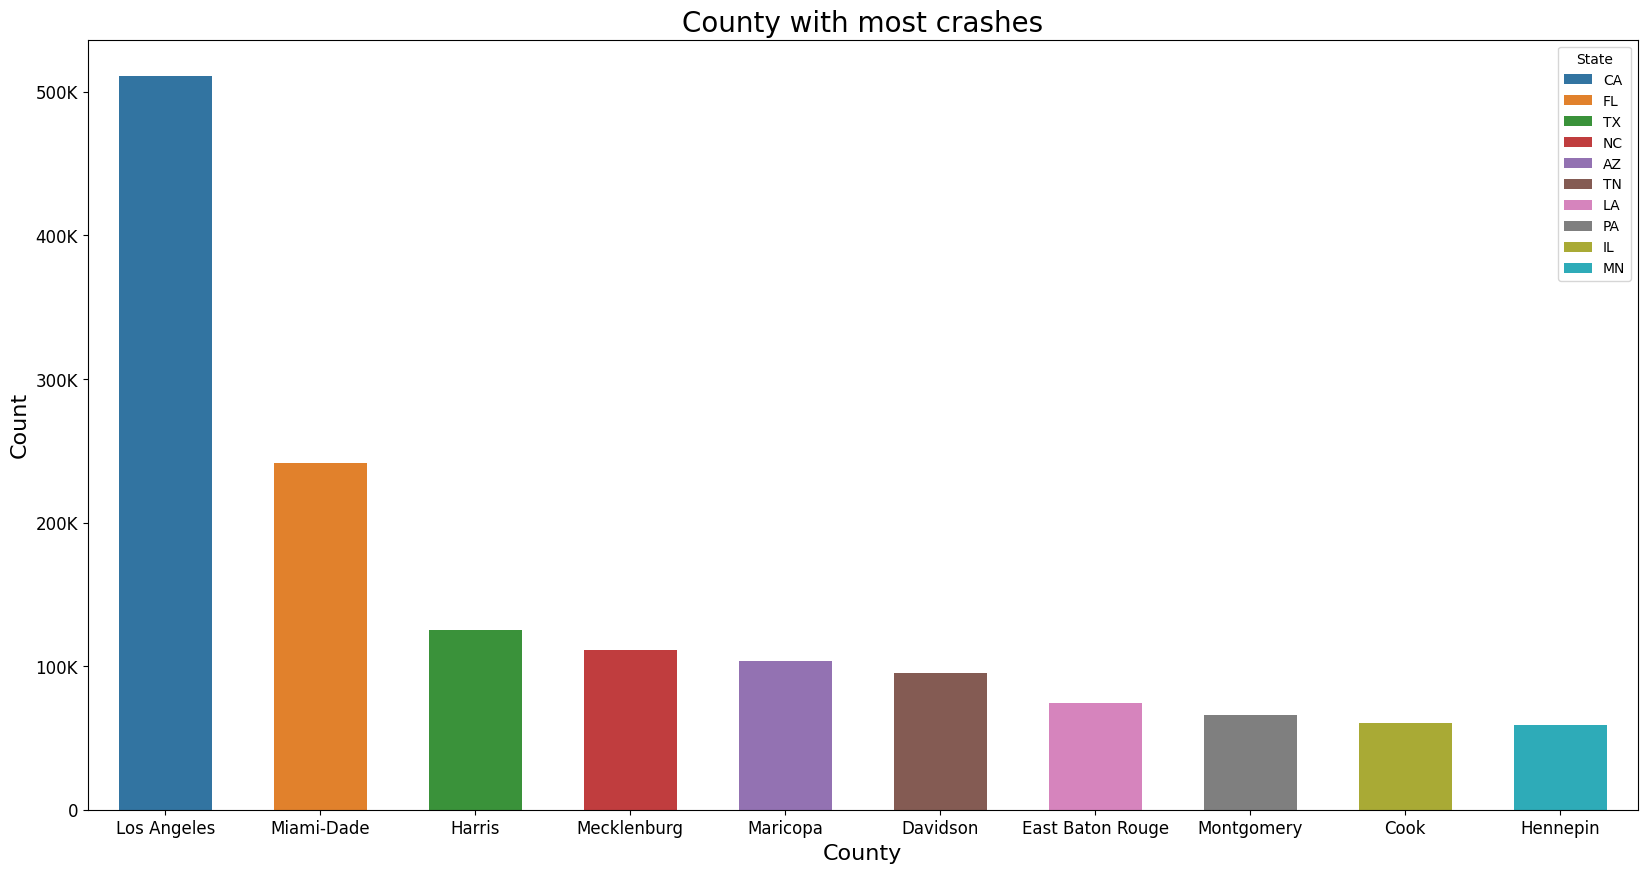

In [84]:
#County with most crashes per State (Top 10 States)
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(1,1,1)
sns.color_palette('deep')
sns.barplot(data=KF2.iloc[:10,:],x='County',y='Count',hue='State',width=0.6)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12)
ax.set_yticklabels(['0','100K','200K','300K','400K','500K'],fontsize=12)
ax.set_title('County with most crashes',fontsize=20)
ax.set_xlabel('County',fontsize=16)
ax.set_ylabel('Count',fontsize=16)

/tmp/ipython-input-2487190097.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(['0','250K','500K','750K','1M','1.25M','1.5M','1.75M'],
/tmp/ipython-input-2487190097.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=11)
/tmp/ipython-input-2487190097.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([tick.get_text()[:3] for tick in ax2.get_xticklabels()],
/tmp/ipython-input-2487190097.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['0','100K','200K','300K','400K','500K',
/tmp/ipython-input-2487190097.py:33: UserWarning: set_ticklabel

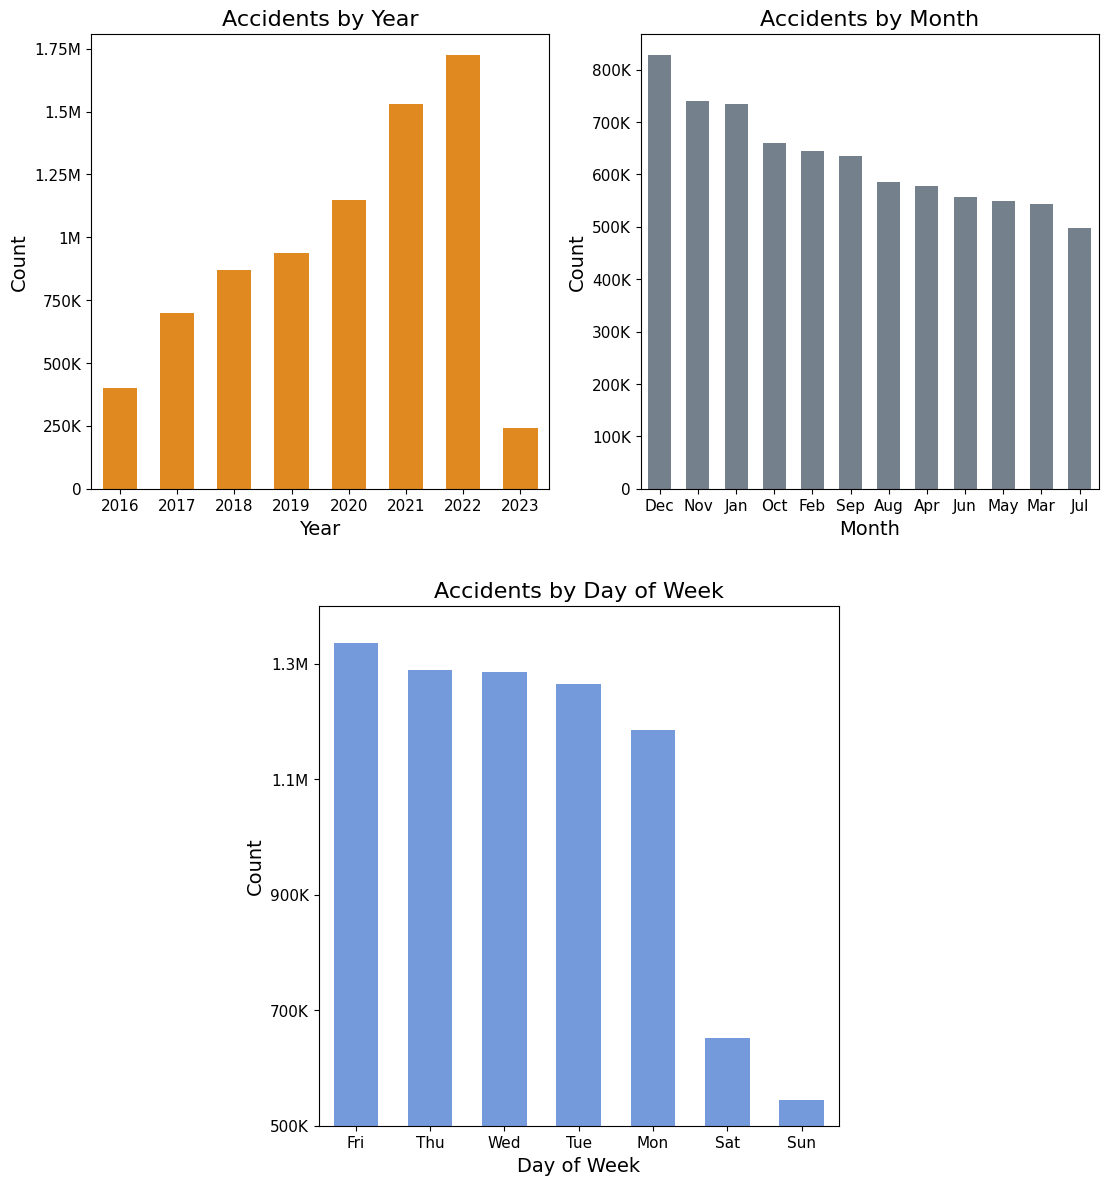

In [85]:
#Accidents Per Year, Month, Day of Week
fig=plt.figure(figsize=(13,13))
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)
#Accidents by Year
sns.barplot(data=KF3,ax=ax1,x='Year',y='Count',width=0.6,color='darkorange')
ax1.set_xlabel('Year',fontsize=14)
ax1.set_ylabel('Count',fontsize=14)
ax1.set_title('Accidents by Year',fontsize=16)
ax1.set_yticklabels(['0','250K','500K','750K','1M','1.25M','1.5M','1.75M'],
                    fontsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=11)
#Accidents by Month
sns.barplot(data=KF4,ax=ax2,x='Month',y='Count',width=0.6,color='slategrey')
ax2.set_xticklabels([tick.get_text()[:3] for tick in ax2.get_xticklabels()],
                    fontsize=11)
ax2.set_yticklabels(['0','100K','200K','300K','400K','500K',
                     '600K','700K','800K'],
                    fontsize=11)
ax2.set_xlabel('Month',fontsize=14)
ax2.set_ylabel('Count',fontsize=14)
ax2.set_title('Accidents by Month',fontsize=16)
#Accidents by Day of Week
sns.barplot(data=KF5,ax=ax3,x='Day_of_Week',y='Count',width=0.6,
            color='cornflowerblue')
ax3.set_ylim(500000,1400000)
ax3.set_yticks([500000,700000,900000,1100000,1300000])
ax3.set_yticklabels(['500K','700K','900K','1.1M','1.3M'],fontsize=11)
ax3.set_xlabel('Day of Week',fontsize=14)
ax3.set_ylabel('Count',fontsize=14)
ax3.set_title('Accidents by Day of Week',fontsize=16)
ax3.set_xticklabels([tick.get_text()[:3] for tick in ax3.get_xticklabels()],
                    fontsize=11)
ax3.set_position([0.3,0.04,0.40,0.40])



In [86]:
KF6

,Temp_Bin,Count
2,Cool-Mid Cool,1858521
3,Mild-Comfortable,1693460
1,Cold,1422222
4,Warm,1414258
0,Very Cold,612336
5,Hot,473166
6,Very Hot,80730


/tmp/ipython-input-3916688274.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=11)
/tmp/ipython-input-3916688274.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0','250K','500K','750K','1M','1.25M','1.5M','1.75M'],


Text(0.5, 1.0, 'Accidents by Temperature Bin')

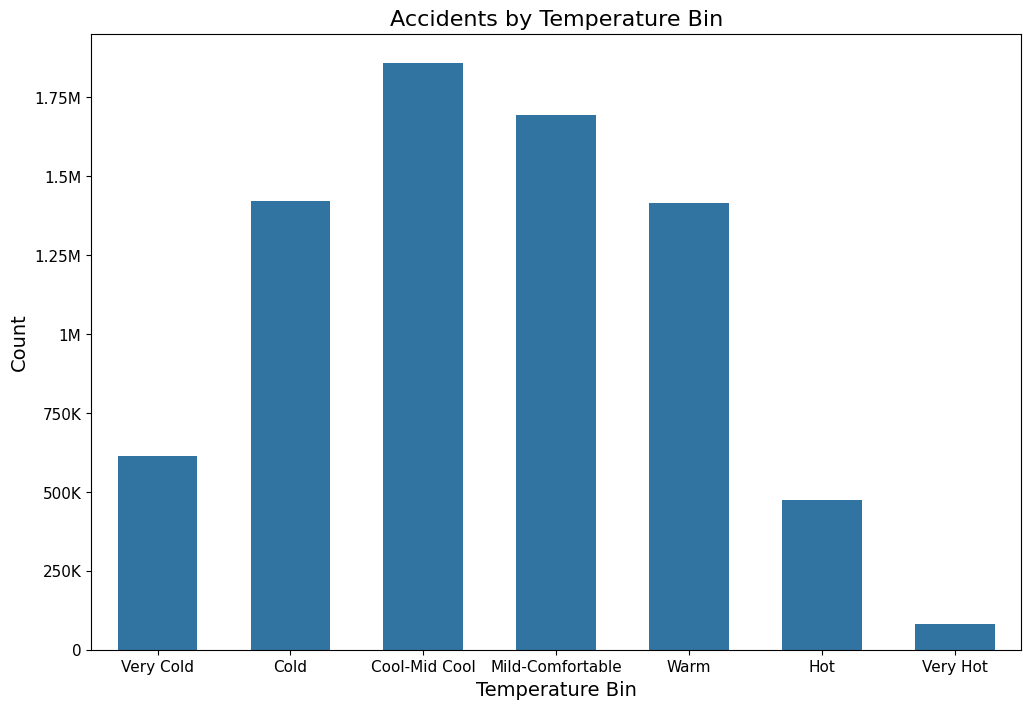

In [87]:
#Accidents per Temp Bin
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(1,1,1)
sns.barplot(data=KF6,x='Temp_Bin',y='Count',width=0.6)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=11)
ax.set_yticklabels(['0','250K','500K','750K','1M','1.25M','1.5M','1.75M'],
                   fontsize=11)
ax.set_xlabel('Temperature Bin',fontsize=14)
ax.set_ylabel('Count',fontsize=14)
ax.set_title('Accidents by Temperature Bin',fontsize=16)

###**CUDF**

In [93]:
#Dataframes (to avoid class objects)
CF1=cudf.DataFrame(CF1)
CF2=cudf.DataFrame(CF2)
CF3=cudf.DataFrame(CF3)

/tmp/ipython-input-2930428461.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=11)
/tmp/ipython-input-2930428461.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0','100K','200K','300K','400K','500K'],


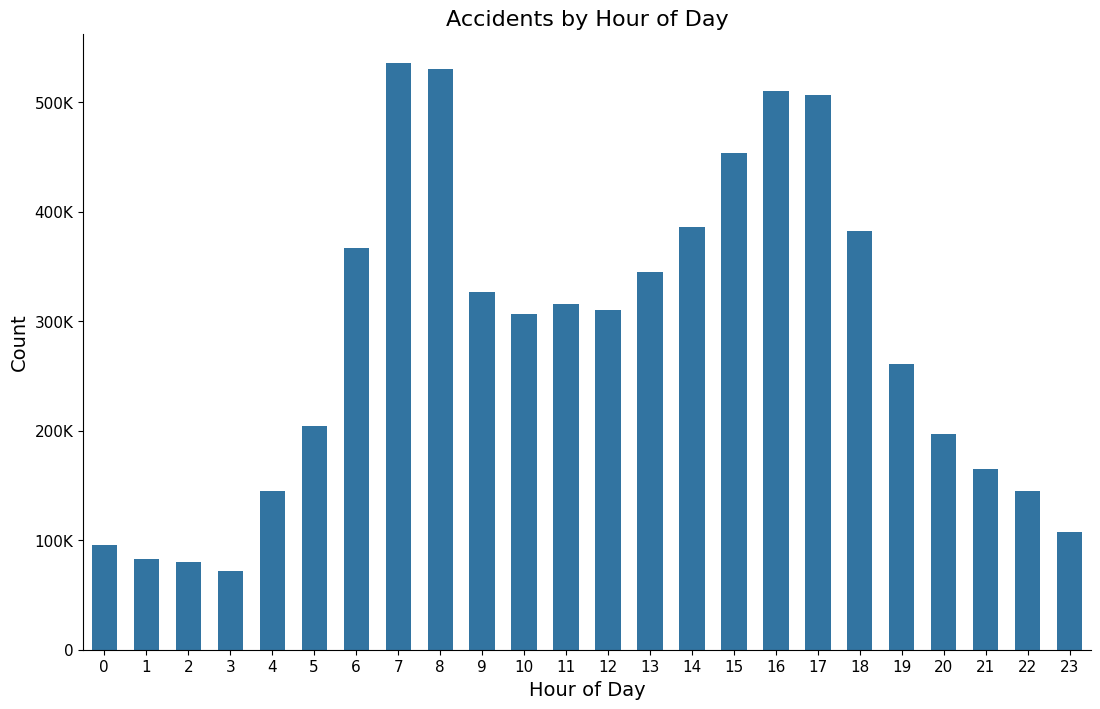

In [102]:
#Creating Plot
fig=plt.figure(figsize=(13,8))
ax=fig.add_subplot(1,1,1)
#Since CUDF is not working well with Seaborn we are sending them back to pandas
sns.barplot(data=CF1.to_pandas(),x='Hour',y='Count',width=0.6)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=11)
ax.set_yticklabels(['0','100K','200K','300K','400K','500K'],
                   fontsize=11)
ax.set_xlabel('Hour of Day',fontsize=14)
ax.set_ylabel('Count',fontsize=14)
ax.set_title('Accidents by Hour of Day',fontsize=16)
sns.despine()

/tmp/ipython-input-3087890206.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0','500K','1M','1.5M','2M','2.5M'],


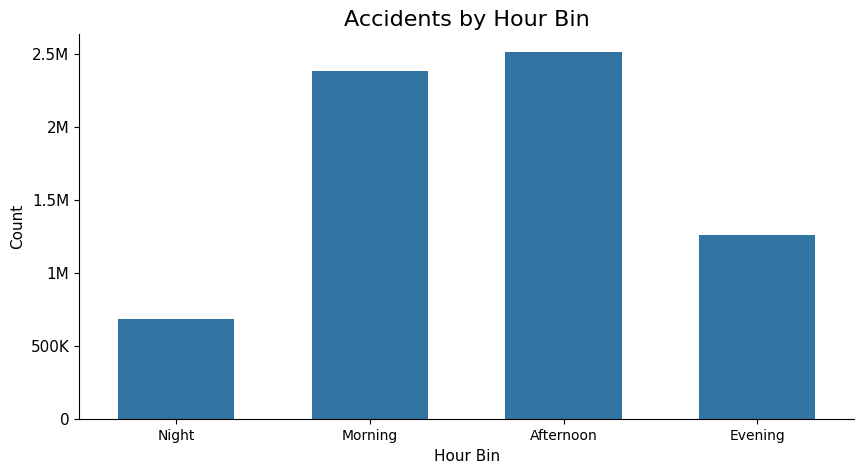

In [105]:
#Hour Bin with Most Crashes
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)
sns.barplot(data=CF2.to_pandas(),x='Hour_Bin',y='Count',width=0.6)
ax.set_yticklabels(['0','500K','1M','1.5M','2M','2.5M'],
                   fontsize=11)
ax.set_xlabel('Hour Bin',fontsize=11)
ax.set_ylabel('Count',fontsize=11)
ax.set_title('Accidents by Hour Bin',fontsize=16)
sns.despine()

/tmp/ipython-input-1110628980.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=10)
/tmp/ipython-input-1110628980.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)


Text(0.5, 1.0, 'Hour with Most Accidents per State')

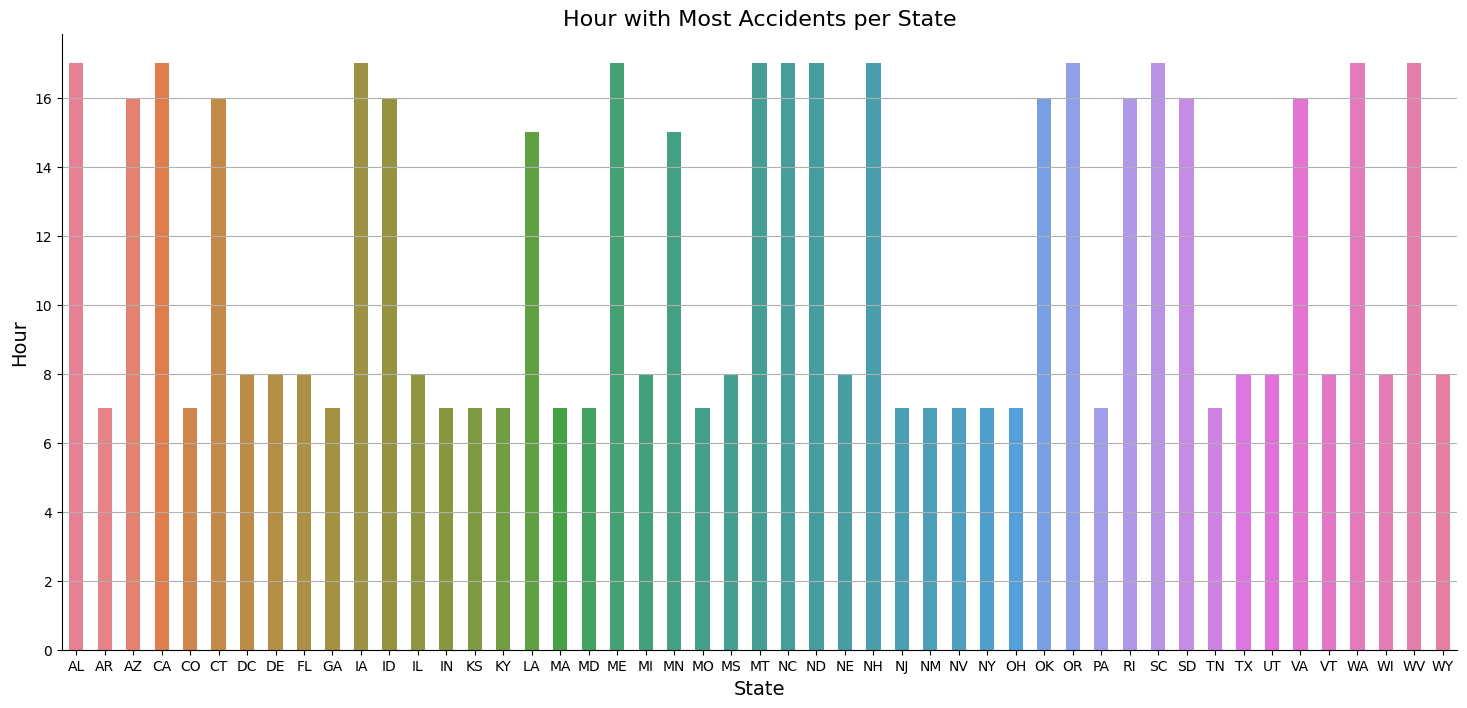

In [124]:
#Hour with Most Accidents per State
fig=plt.figure(figsize=(18,8))
ax=fig.add_subplot(1,1,1)
sns.barplot(data=CF3.to_pandas(),x='State',y='Hour',hue='State',width=0.5)
ax.grid(axis='y',which='major')
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(),fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)
ax.set_xlabel('State',fontsize=14)
ax.set_ylabel('Hour',fontsize=14)
ax.set_title('Hour with Most Accidents per State',fontsize=16)

###**Statistical Properties**
We will provide a simple histogram for Accident Duration Distribution in Hours.

In [127]:
#Taking a sample of 500K rows
cf_sample=cf.sample(n=500000)

In [142]:
cf_sample.head()

,ID,Source,Severity,Start_Time,End_Time,Distance(mi),City,County,State,Zipcode,...,Crossing,Give_Way,Railway,Roundabout,Stop,Traffic_Calming,Time_Delta,Hour,Hour_Bin,Accident_Duration_Minutes
47327,A-47890,Source2,3,2016-07-11 10:54:04,2016-07-11 11:39:04,0.000,National City,San Diego,CA,91950,...,False,False,False,False,False,False,0 days 00:45:00,10,Morning,45.000000
3442812,A-3520453,Source1,4,2016-05-26 10:25:17,2016-05-26 16:25:17,1.235,Auburn,Rockingham,NH,03032-3502,...,False,False,False,False,False,False,0 days 06:00:00,10,Morning,360.000000
3507294,A-3586376,Source1,2,2017-03-07 20:51:10,2017-03-08 02:51:10,0.839,Phoenix,Maricopa,AZ,85015,...,False,False,False,False,False,False,0 days 06:00:00,20,Evening,360.000000
2662598,A-2720015,Source2,2,2018-07-23 14:06:33,2018-07-23 14:36:12,0.000,Anaheim,Orange,CA,92808,...,False,False,False,False,False,False,0 days 00:29:39,14,Afternoon,29.650000
5757179,A-6656861,Source1,2,2020-12-22 12:45:30,2020-12-23 02:25:04,0.435,Baton Rouge,East Baton Rouge,LA,70809,...,False,False,False,False,False,False,0 days 13:39:34,12,Afternoon,819.566667


In [146]:
cf_sample['Accident_Duration_Hours']=(cf['Time_Delta'].dt.seconds/3600)

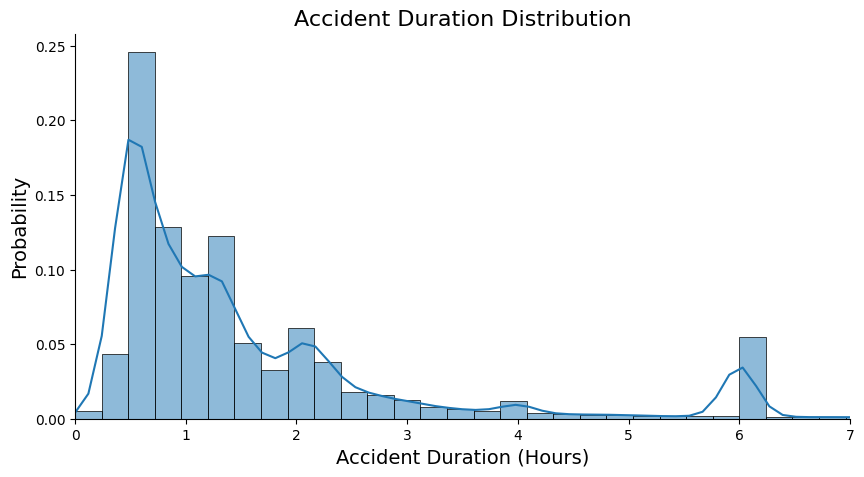

In [160]:
#Time_Delta Distribution
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)
sns.histplot(data=cf_sample.to_pandas(),ax=ax,x='Accident_Duration_Hours',
             stat='probability',bins=100, kde=True)
ax.set_xlim(0,7)
ax.set_xlabel('Accident Duration (Hours)',fontsize=14)
ax.set_ylabel('Probability',fontsize=14)
ax.set_title('Accident Duration Distribution',fontsize=16)
sns.despine()

##**Step 7: Conclusion**
Through this exploratory analysis, we examined the evolution of traffic accidents across the years 2016–2022 (as the dataset contains partial data for 2023). The analysis explored both geographical and temporal patterns identifying key factors such as location, time of day, day of week, and weather conditions that correlate with accident frequency.

**Key Findings**



*  Top States and Counties:

The states with the highest number of crashes are California (CA), Florida (FL), and Texas (TX) — with Los Angeles, Miami-Dade, and Harris counties leading respectively.

*  Yearly Trend:

A significant upward trend was observed in total accidents, rising from approximately 400K in 2016 to 1.75M in 2022.

*  Monthly Distribution:

December recorded the highest number of crashes, followed by November, while July consistently showed the fewest.

*  Day of Week:

Fridays have the most crashes, with a steady increase from Monday to Friday, suggesting higher traffic activity as the week progresses.

*  Temperature Conditions:

Contrary to common expectations, most accidents occurred between 10–18°C, followed by 18–24°C, with fewer crashes below 10°C.
This suggests that extreme cold or heat may reduce overall travel activity, leading to fewer accidents.

*  Time of Day:

Peak accident hours were around 7–8 AM and 4–5 PM, aligning with commuting periods, though overall the afternoon hours (12–18) showed the highest cumulative crash counts.

*  Accident Duration:

Based on a random sample of 500K records (out of 6.8M), the majority of crashes lasted between 35–45 minutes, indicating a typical response and clearance window for incidents.